# This kernel is:
- Based on [Very fst Model](https://www.kaggle.com/ragnar123/very-fst-model). Thanks [@ragnar123](https://www.kaggle.com/ragnar123).
- Automatically uploaded by [push-kaggle-kernel](https://github.com/harupy/push-kaggle-kernel).
- Formatted by [Black](https://github.com/psf/black).

# Objective

* Make a baseline model that predict the validation (28 days).
* This competition has 2 stages, so the main objective is to make a model that can predict the demand for the next 28 days.

In [1]:
import gc
import os
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [2]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [3]:
def on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

In [4]:
if on_kaggle():
    os.system("pip install --quiet mlflow_extend")

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
def read_data():
    INPUT_DIR = "/kaggle/input/m5-forecasting-accuracy" if on_kaggle() else '../data/raw'

    print("Reading files...")

    calendar = pd.read_csv(f"{INPUT_DIR}/calendar.csv").pipe(reduce_mem_usage)
    sell_prices = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv").pipe(reduce_mem_usage)

    # Limit the number of columns to use to prevent OOM error.
    sales_train_val = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

    print("calendar shape:", calendar.shape)
    print("sell_prices shape:", sell_prices.shape)
    print("sales_train_val shape:", sales_train_val.shape)
    print("submission shape:", submission.shape)

    # calendar shape: (1969, 14)
    # sell_prices shape: (6841121, 4)
    # sales_train_val shape: (30490, 1919)
    # submission shape: (60980, 29)

    return calendar, sell_prices, sales_train_val, submission

In [7]:
calendar, sell_prices, sales_train_val, submission = read_data()

NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
calendar shape: (1969, 14)
sell_prices shape: (6841121, 4)
sales_train_val shape: (30490, 1919)
submission shape: (60980, 29)


As [@kaushal2896](https://www.kaggle.com/kaushal2896) suggested in [this comment](https://www.kaggle.com/harupy/m5-baseline#770558), encode the categorical columns before merging to prevent the notebook from crashing even with the full dataset.

In [8]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 94.01 Mb (1.0% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [9]:
def melt(
    sales_train_val, submission, nrows=55_000_000, verbose=True,
):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # get product table.
    product = sales_train_val[id_columns]

    sales_train_val = pd.melt(
        sales_train_val, id_vars=id_columns, var_name="day", value_name="demand",
    )

    sales_train_val = reduce_mem_usage(sales_train_val, verbose=False)

    if verbose:
        print("melted")
        display(sales_train_val)

    # separate test dataframes.
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    vals = pd.melt(vals, id_vars=id_columns, var_name="day", value_name="demand")
    evals = pd.melt(evals, id_vars=id_columns, var_name="day", value_name="demand")

    sales_train_val["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales_train_val, vals, evals], axis=0)

    del sales_train_val, vals, evals

    # get only a sample for fast training.
    data = data.loc[nrows:]

    # delete evaluation for now.
    data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    # drop some calendar features.
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)

    # notebook crashes with the entire dataset.
    data = pd.merge(data, calendar, how="left", left_on=["day"], right_on=["d"])
    return data.drop(["d", "day"], axis=1)


def merge_sell_prices(data, sell_prices):
    # get the sell price data (this feature should be very important).
    return data.merge(sell_prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [10]:
data = melt(sales_train_val, submission, nrows=27_500_000)
del sales_train_val
gc.collect()

data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_sell_prices(data, sell_prices)
del sell_prices
gc.collect()

data = reduce_mem_usage(data)

melted


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


validation


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


data


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
27500000,HOUSEHOLD_1_514_WI_3_validation,2506,5,2,9,2,d_902,16,train
27500001,HOUSEHOLD_1_515_WI_3_validation,2507,5,2,9,2,d_902,1,train
27500002,HOUSEHOLD_1_516_WI_3_validation,2508,5,2,9,2,d_902,1,train
27500003,HOUSEHOLD_1_517_WI_3_validation,2509,5,2,9,2,d_902,1,train
27500004,HOUSEHOLD_1_518_WI_3_validation,2510,5,2,9,2,d_902,0,train


Mem. usage decreased to 1661.74 Mb (0.0% reduction)


In [11]:
def add_demand_features(df):
    # rolling demand features.
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )

    for size in [7, 30, 60, 90, 180]:
        df[f"rolling_std_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).std()
        )

    for size in [7, 30, 60, 90, 180]:
        df[f"rolling_mean_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(size).mean()
        )

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()
    )
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()
    )
    return df


def add_price_features(df):
    # price features
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
        "is_year_end",
        "is_year_start",
        "is_quarter_end",
        "is_quarter_start",
        "is_month_end",
        "is_month_start",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    return df

In [12]:
data = add_demand_features(data).pipe(reduce_mem_usage)
data = add_price_features(data).pipe(reduce_mem_usage)
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

Mem. usage decreased to 2568.14 Mb (51.4% reduction)
Mem. usage decreased to 2809.85 Mb (0.0% reduction)
Mem. usage decreased to 3232.84 Mb (0.0% reduction)
start date: 2013-07-18 00:00:00
end date: 2016-05-22 00:00:00
data shape: (31681090, 50)


In [13]:
def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [14]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

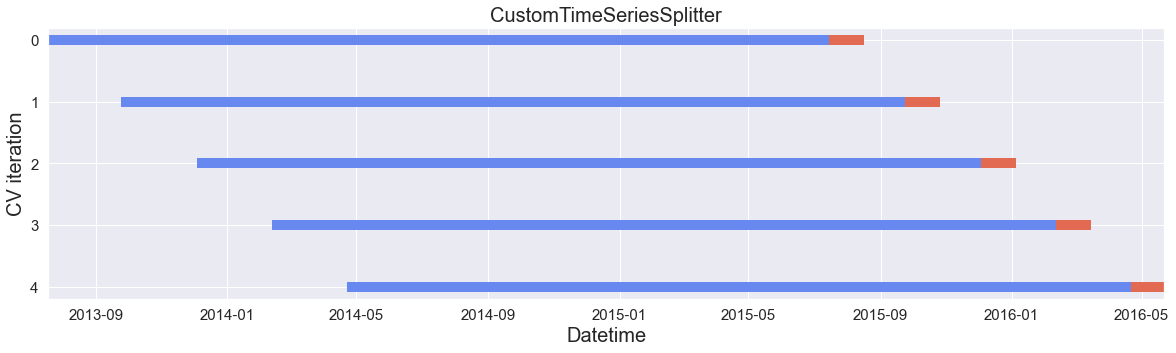

In [15]:
cv_params = {
    "n_splits": 5,
    "train_days": 365 * 2,
    "test_days": DAYS_PRED,
    "dt_col": dt_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)
# Plotting all the points takes long time.
plot_cv_indices(cv, data.iloc[::1000][[dt_col]].reset_index(drop=True), None, dt_col)

Blue: train, Orange: test

In [16]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend",
]

# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

mask = data["date"] <= "2016-04-24"

# Attach "date" to X_train for cross validation.
X_train = data[mask][["date"] + features].reset_index(drop=True)
y_train = data[mask]["demand"].reset_index(drop=True)
X_test = data[~mask][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~mask][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (30827370, 45)
X_test shape: (853720, 44)


In [17]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [18]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[dt_col]
)

del X_train, y_train
gc.collect()


---------- Fold: (1 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.42923	valid's rmse: 2.24237
[200]	train's rmse: 2.36896	valid's rmse: 2.22617
[300]	train's rmse: 2.32947	valid's rmse: 2.21798
[400]	train's rmse: 2.299	valid's rmse: 2.2108
[500]	train's rmse: 2.27459	valid's rmse: 2.20626
[600]	train's rmse: 2.25274	valid's rmse: 2.20135
[700]	train's rmse: 2.23397	valid's rmse: 2.19737
Early stopping, best iteration is:
[704]	train's rmse: 2.23303	valid's rmse: 2.19708

---------- Fold: (2 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.2968	valid's rmse: 2.28334
[200]	train's rmse: 2.24056	valid's rmse: 2.26743
[300]	train's rmse: 2.20608	valid's rmse: 2.25859
[400]	train's rmse: 2.17874	valid's rmse: 2.25175
Early stopping, best iteration is:
[409]	train's rmse: 2.1762	valid's rmse: 2.25109

---------- Fold: (3 / 5) ----------

Training until validation scores don't improve fo

0

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [20]:
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()

# https://github.com/harupy/mlflow-extend

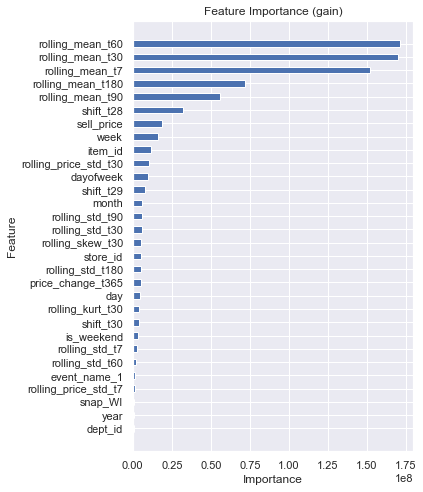

In [23]:
from mlflow_extend import mlflow, plotting as mplt

with mlflow.start_run():
    mlflow.log_params_flatten({"bst": bst_params, "fit": fit_params, "cv": cv_params})


features = models[0].feature_name()
_ = mplt.feature_importance(features, importances, imp_type, limit=30)